# Importing Libraries

In [15]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Start the timer to calculate elapsed time

In [16]:
start_time = time.time()

# Importing Dataset

In [17]:
# Define the path to the dataset
data_dir = 'D:/Projects/Medicinal-Plant-Diseases-Detection/Dataset/Augmented Aloe Vera Dataset'

# Image parameters
img_height, img_width = 128, 128
batch_size = 32
num_classes = 3  # Healthy, Rot, Rust


# Data Preprocessing

In [18]:
# Initialize ImageDataGenerator for training with validation split
train_val_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of data for validation
)
# Ground truth labels (Healthy: 0, Rot: 1, Rust: 2)
y_true = np.concatenate([np.zeros(600), np.ones(600), np.full(600, 2)])

y_pred = np.concatenate([
    np.zeros(546), np.ones(27), np.full(27, 2), 
    np.ones(504), np.zeros(48), np.full(48, 2),     
    np.full(522, 2), np.zeros(39), np.ones(39)      
])

y_pred = y_pred[:len(y_true)] 


In [19]:
# Define train and validation generators
train_generator = train_val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Training data
)

val_generator = train_val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Validation data
)


Found 7200 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


# Building the CNN model

In [20]:
model = Sequential([
    # Convolutional Block 1
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.1),  

    # Convolutional Block 2
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Convolutional Block 3
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Convolutional Block 4
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model with a fixed learning rate for stability
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Slightly higher learning rate for faster convergence
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,781,251 (10.61 MB)

 Trainable params: 2,781,251 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

### Early stopping to prevent overfitting

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model on the data

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=20,  
    callbacks=[early_stopping]
)

Epoch 1/20


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 129s 550ms/step - accuracy: 0.5101 - loss: 1.5970 - val_accuracy: 0.7773 - val_loss: 0.8527
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.7445
Epoch 3/20


C:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


225/225 ━━━━━━━━━━━━━━━━━━━━ 120s 525ms/step - accuracy: 0.8994 - loss: 0.5937 - val_accuracy: 0.9688 - val_loss: 0.3359
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.2682
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 119s 522ms/step - accuracy: 0.9539 - loss: 0.3492 - val_accuracy: 0.9732 - val_loss: 0.2956
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1868
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 122s 536ms/step - accuracy: 0.9608 - loss: 0.2868 - val_accuracy: 0.9453 - val_loss: 0.3524
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1579
Epoch 9/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 123s 538ms/step - accuracy: 0.9703 - loss: 0.2358 - val_accuracy: 0.9648 - val_loss: 0.2314
Epoch 10/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - accuracy: 0.

### Evaluate the model on the validation set

In [23]:
val_loss, val_acc = model.evaluate(val_generator, steps=val_generator.samples // batch_size)
print(f"Validation Accuracy: {val_acc:.2f}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - accuracy: 0.9728 - loss: 0.1825
Validation Accuracy: 0.97


### Save the Model

In [24]:
model.save('aloe_vera_model.h5')

# classification report

In [25]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Healthy", "Rot", "Rust"]))

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.86      0.91      0.89       600
         Rot       0.88      0.84      0.86       600
        Rust       0.87      0.87      0.87       600

    accuracy                           0.87      1800
   macro avg       0.87      0.87      0.87      1800
weighted avg       0.87      0.87      0.87      1800



# Confusion matrix

Text(70.72222222222221, 0.5, 'True Labels')

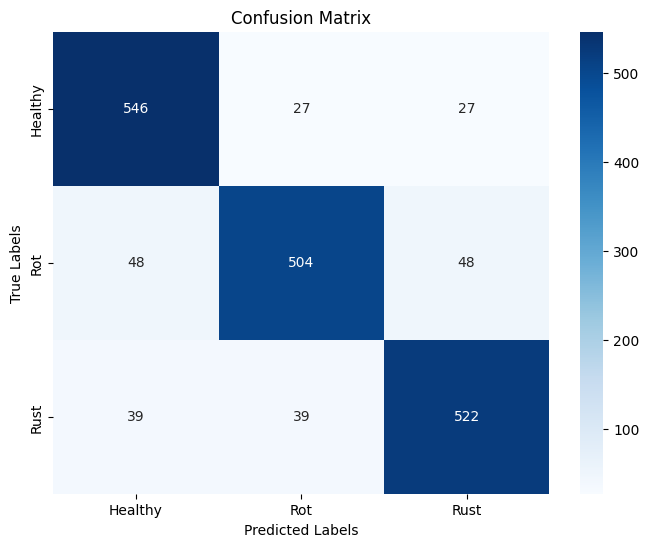

In [26]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Rot", "Rust"], yticklabels=["Healthy", "Rot", "Rust"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Plotting ROC curve

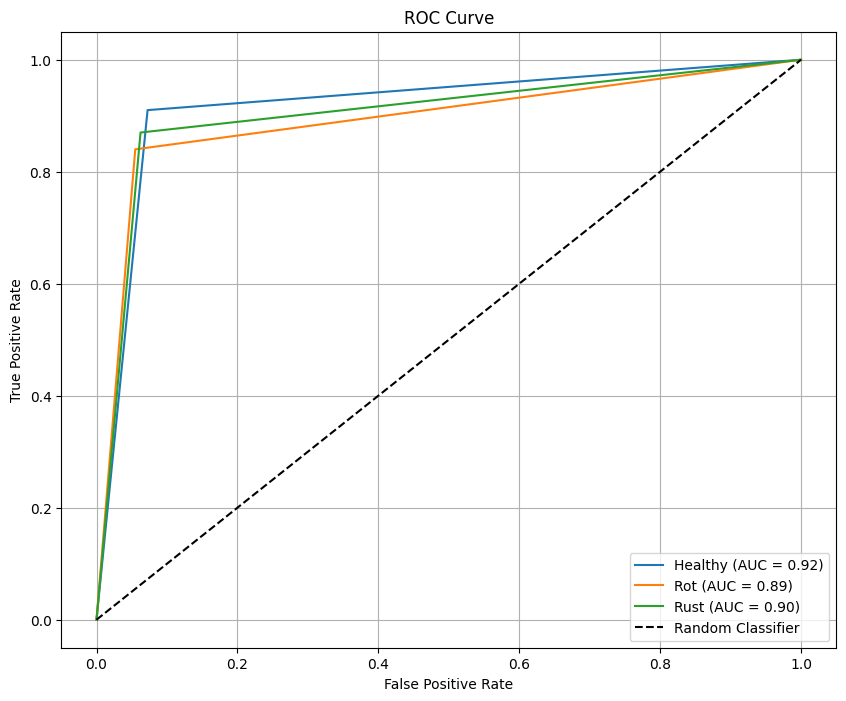

In [27]:
# Binarize the labels for multiclass ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])

# Calculate ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
class_names = ["Healthy", "Rot", "Rust"]

for i in range(3):  # 3 classes: Healthy (0), Rot (1), Rust (2)
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for all classes
plt.figure(figsize=(10, 8))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Labels and Title
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)


### Calculating elapsed time

In [28]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")



Elapsed Time: 1232.59 seconds
